In [1]:
# Developer: Luis Carlos Herrera Quesada
# Date: 23/05/2023
# Universidad Carlos III de Madrid

## Surface Representations from VMEC file ("wout")

Necessary libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.netcdf as netcdf
import plotly.graph_objects as go
from matplotlib import cm

Extract main data: 
<br>
* rmnc = Fourier coefficients for the radial values
* zmnc = Fourier coefficients for the z values
* r1 = Major radius
* r2 = Minor radius
* itor = toroidal modes
* ipol = poloidal modes
* n_surf = number of surfaces
* Nf = number of field periods for device

In [3]:
def get_values(vmec_file):
    # Extract data
    rmnc = vmec_file.variables['rmnc'][:]
    zmns = vmec_file.variables['zmns'][:]
    lmns = vmec_file.variables['lmns'][:] #lambda
    bmnc = vmec_file.variables['bmnc'][:]

    r1 = vmec_file.variables['Rmajor_p'].getValue() 
    r2 = vmec_file.variables['Aminor_p'].getValue() 

    itor = vmec_file.variables['xn'][:]  
    ipol = vmec_file.variables['xm'][:]  
    n_surf = vmec_file.variables['ns'].getValue()  
    Nf = vmec_file.variables['nfp'].getValue() 
    n_imode = len(itor)
    
    return rmnc, zmns, itor, ipol, n_surf,n_imode

In [4]:
def mesh_toroidal_coordinates(res):
    # Construct flux coordinates grid
    phi = np.linspace(0, 2*np.pi, res)
    theta = np.linspace(0, 2*np.pi, res)
    Theta, Phi = np.meshgrid(theta, phi)
    
    return Theta, Phi

# Magnetic Surface

The next function creates a grid of ($\varphi$,$\vartheta$) coordinates, then creates empty matrices for coordinates R and Z and finally computes the magnetic surface data

In [5]:
def magnetic_surface_data(rmnc, zmns, ipol, itor, n_imode, res, isurf):
    
    Theta, Phi = mesh_toroidal_coordinates(res)
    #defines the matrix for (R,Z)
    R,Z = np.empty((n_surf,res,res)), np.empty((n_surf,res,res))
    
    for i_phi in range(res): 
        for i_theta in range(res):
            R[isurf,i_phi,i_theta] = 0
            Z[isurf,i_phi,i_theta] = 0
            for imode in range(n_imode):
                R[isurf,i_phi,i_theta] += rmnc[isurf,imode] * np.cos( (ipol[imode] * Theta[i_phi,i_theta]) - (itor[imode] * Phi[i_phi,i_theta]) )
                Z[isurf,i_phi,i_theta] += zmns[isurf,imode] * np.sin( (ipol[imode] * Theta[i_phi,i_theta]) - (itor[imode] * Phi[i_phi,i_theta]) )
                
    return R,Z

Next function obtains the cartesian coordinates

In [6]:
def cartesian_coordinates_change(r,z,res,n_surf):
    Theta, Phi = mesh_toroidal_coordinates(res)
    X,Y = np.empty((n_surf,res,res)), np.empty((n_surf,res,res))
    X = R * np.cos(Phi)
    Y = R * np.sin(Phi)
    
    return X,Y

#When paralelization is available.
<br>
for isurf in range(n_surf):
    for i_phi in range(len(phi)): 
        for i_theta in range(len(theta)):
            R[isurf,i_phi,i_theta] = 0
            Z[isurf,i_phi,i_theta] = 0
            for imode in range(n_imode):
                R[isurf,i_phi,i_theta] += rmnc[isurf,imode] * np.cos( (ipol[imode] * Theta[i_phi,i_theta]) - (itor[imode] * Phi[i_phi,i_theta]) )
                Z[isurf,i_phi,i_theta] += zmns[isurf,imode] * np.sin( (ipol[imode] * Theta[i_phi,i_theta]) - (itor[imode] * Phi[i_phi,i_theta]) )

Creates empty matrices for X and Y and transforms R and Z to cartesian

In [7]:
# Load wout file and extrac data
device = "TJ-II"
wout_file = netcdf.netcdf_file("wout_files/wout_tj2curref.nc", 'r')
rmnc, zmns, itor, ipol, n_surf, n_imode = get_values(wout_file)

resolution = 100 #defines (phi,theta) resolution
surface = 100    #defines magnetic surface to plot

In [14]:
R,Z = magnetic_surface_data(rmnc, zmns, ipol, itor, n_imode,resolution,surface)
X,Y = cartesian_coordinates_change(R,Z,resolution,n_surf)

### Magnetic Surface Plot

In [15]:
fig = go.Figure(data=[go.Surface(z=Z[surface,:,:], x=X[surface,:,:], y=Y[surface,:,:], 
                                 colorscale="inferno", showscale=False)])

fig.update_layout(title={
                        "text": f'Magnetic Surface {device}',
                        "x": 0.5,
                        "y": 0.85,
                        "xanchor": "center",
                        "font":{"family":"Arial","size":30}
                        }, 
                  autosize=False,
                  scene=dict(
                         zaxis = dict(range = [-1,1]) ))

fig.write_image(f"{device}_device.png",height=1000,width=800,scale=2)

config = {
    'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': f'{device}_device',
    'height': 1000,
    'width': 800,
    'scale':6 # Multiply title/legend/axis/canvas sizes by this factor
  }
}

fig.show()

# Plots the poloidal proyection in the given toroidal angle

In [8]:
def poloidal_cut_data(rmnc, zmns, ipol, itor, n_imode, res, i_phi):
    
    Theta, Phi = mesh_toroidal_coordinates(res)
    
    #defines the matris for (r,z)
    R,Z = np.empty((n_surf,res,res)), np.empty(((n_surf,res,res)))
    
    for isurf in range(n_surf): 
        for i_theta in range(res):
            R[isurf,i_phi,i_theta] = 0
            Z[isurf,i_phi,i_theta] = 0
            for imode in range(n_imode):
                R[isurf,i_phi,i_theta] += rmnc[isurf,imode] * np.cos( (ipol[imode] * Theta[i_phi,i_theta]) - (itor[imode] * Phi[i_phi,i_theta]) )
                Z[isurf,i_phi,i_theta] += zmns[isurf,imode] * np.sin( (ipol[imode] * Theta[i_phi,i_theta]) - (itor[imode] * Phi[i_phi,i_theta]) )
                
    return R,Z

In [9]:
phi_angle = 0
R,Z = poloidal_cut_data(rmnc, zmns, ipol, itor, n_imode, resolution, phi_angle)
X,Y = cartesian_coordinates_change(R,Z,resolution,n_surf)

<IPython.core.display.Javascript object>


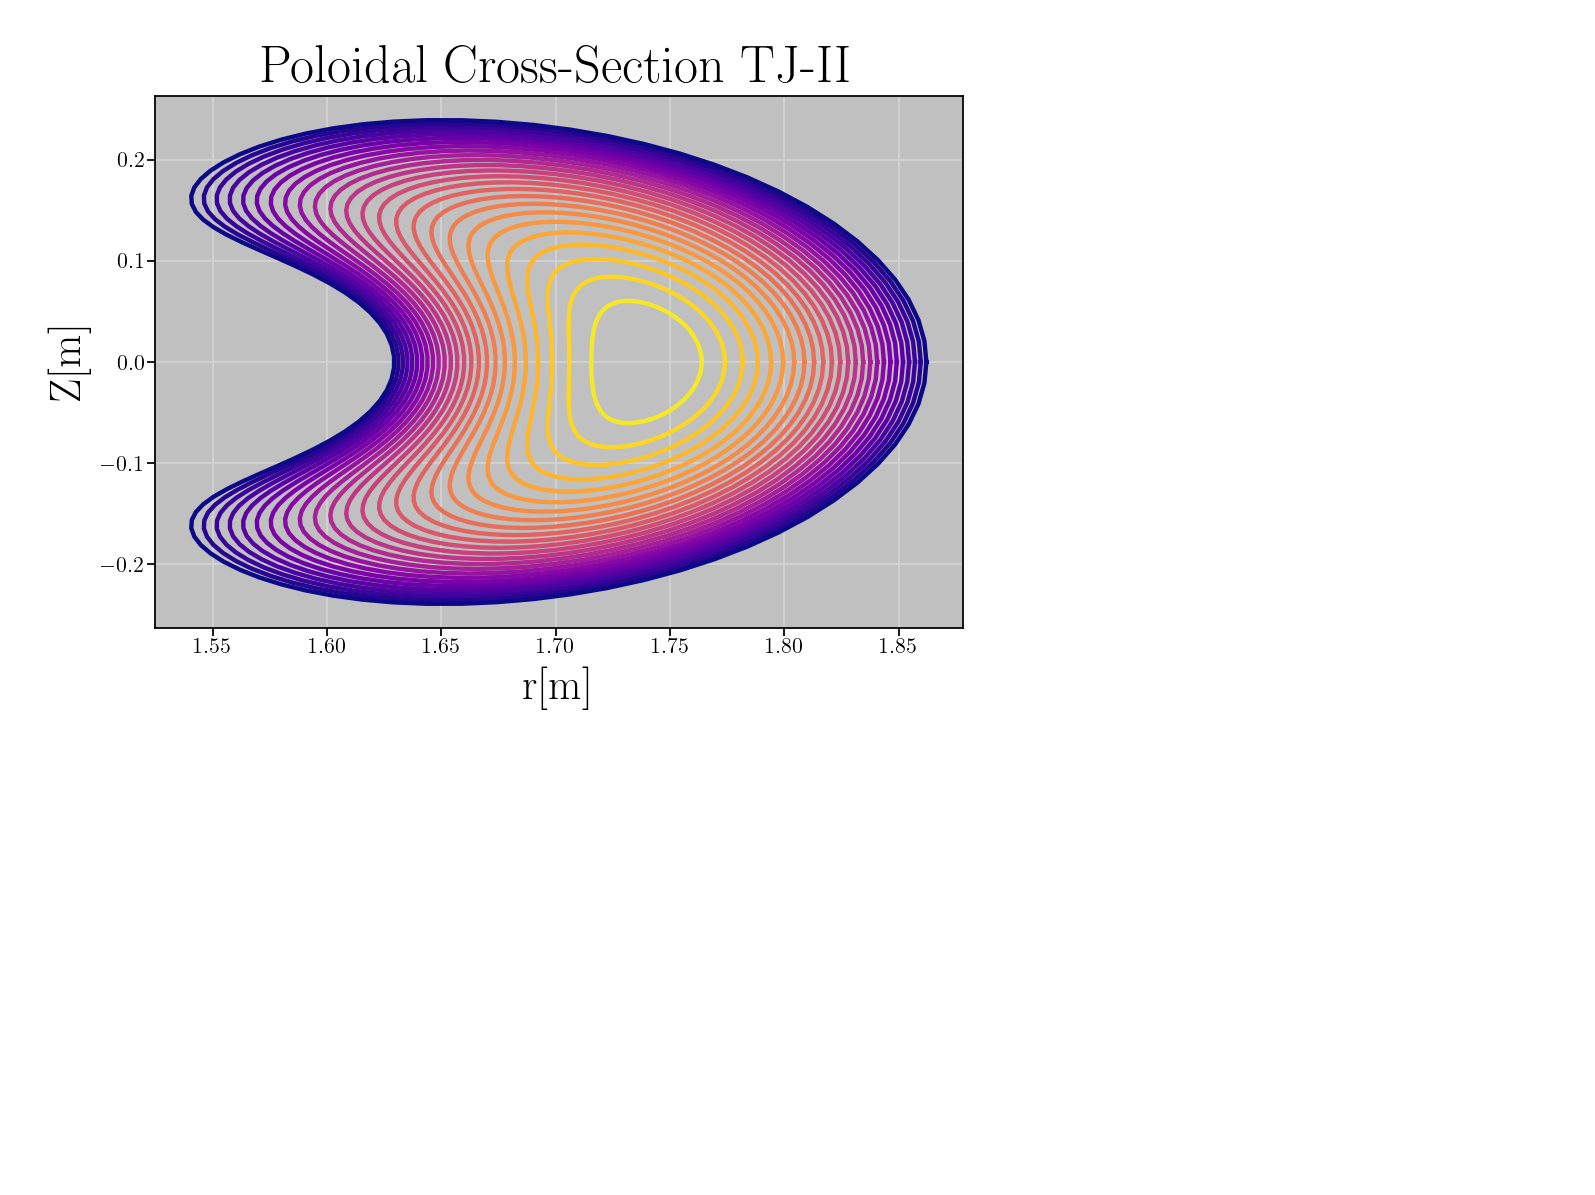

In [34]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111)

# Create a colormap
cmap = cm.get_cmap('plasma_r')

# Plot the lines with varying colors
for i in range(0,n_surf,4):
    color = cmap(i/(100))  # Normalize i to [0, 1]
    ax.plot(X[i,phi_angle,:],Z[i,phi_angle,:],color=color,linewidth=2)

ax.set_xlabel(f'r[m]')
ax.set_ylabel(f'Z[m]')
ax.set_title(f"Poloidal Cross-Section {device}")
ax.set_facecolor('silver')

ax.xaxis.set_tick_params(labelsize=10,pad=1)
ax.yaxis.set_tick_params(labelsize=10,pad=1)
plt.show()

In [18]:
plt.savefig(f"Poloidal_CS_{phi_angle}_device_{device}.png",dpi=500)